## Road segmentation using Hybrid model (EfficientPS and Mask2Former)

In [18]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, UpSampling2D, Concatenate, Input, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [19]:
EPOCHS = 25
BATCH_SIZE = 10
HEIGHT = 256
WIDTH = 256
N_CLASSES = 13

## Loading Dataset (Cityscape)

In [20]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    image = img[:, :256]
    mask = img[:, 256:]
    return image, mask

def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

def getSegmentationArr(image, classes, width=WIDTH, height=HEIGHT):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, :, 0]
    for c in range(classes):
        seg_labels[:, :, c] = (img == c).astype(int)
    return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3)).astype('float')
    colors = sns.color_palette("hls", n_classes)
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:, :, 0] += (segc * colors[c][0])
        seg_img[:, :, 1] += (segc * colors[c][1])
        seg_img[:, :, 2] += (segc * colors[c][2])
    return seg_img

# Data Generator

def DataGenerator(path, batch_size=BATCH_SIZE, classes=N_CLASSES):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i: i + batch_size]
            imgs, segs = [], []
            for file in batch_files:
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)
                imgs.append(image)
                segs.append(labels)
            yield np.array(imgs), np.array(segs)

# Hybrid Model: EfficientPS + Mask2Former

def hybrid_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
    c = BatchNormalization()(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def transformer_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c = BatchNormalization()(c)
    return c

def HybridSegmentationModel():
    f = [32, 64, 128, 256, 512]
    inputs = Input((HEIGHT, WIDTH, 3))

    c1, p1 = hybrid_block(inputs, f[0])  # EfficientPS Block
    c2, p2 = hybrid_block(p1, f[1])
    c3, p3 = hybrid_block(p2, f[2])
    c4, p4 = hybrid_block(p3, f[3])

    bn = transformer_block(p4, f[4])  # Mask2Former Transformer Block

    u1 = UpSampling2D((2, 2))(bn)
    u1 = Conv2D(f[3], (3, 3), activation='relu', padding='same')(u1)
    u1 = Concatenate()([u1, c4])
    
    u2 = UpSampling2D((2, 2))(u1)
    u2 = Conv2D(f[2], (3, 3), activation='relu', padding='same')(u2)
    u2 = Concatenate()([u2, c3])
    
    u3 = UpSampling2D((2, 2))(u2)
    u3 = Conv2D(f[1], (3, 3), activation='relu', padding='same')(u3)
    u3 = Concatenate()([u3, c2])
    
    u4 = UpSampling2D((2, 2))(u3)
    u4 = Conv2D(f[0], (3, 3), activation='relu', padding='same')(u4)
    u4 = Concatenate()([u4, c1])
    
    outputs = Conv2D(N_CLASSES, (1, 1), padding="same", activation="softmax")(u4)
    
    model = Model(inputs, outputs)
    return model

## Buillding model

In [21]:
model = HybridSegmentationModel()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
checkpoint = ModelCheckpoint('hybrid_seg_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
print(model.summary())

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 256, 256, 32)   │            128 │ conv2d_80[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 256, 256, 32)   │            128 │ conv2d_81[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_82 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_32[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 128, 128, 64)   │            256 │ conv2d_82[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_83 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 128, 128, 64)   │            256 │ conv2d_83[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_84 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_33[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_40    │ (None, 64, 64, 128)    │            512 │ conv2d_84[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_85 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (None, 64, 64, 128)    │            512 │ conv2d_85[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 4,313,421 (16.45 MB)

 Trainable params: 4,310,477 (16.44 MB)

 Non-trainable params: 2,944 (11.50 KB)

None


In [22]:
# Train the model
train_folder = "../input/cityscapes-image-pairs/cityscapes_data/train"
valid_folder = "../input/cityscapes-image-pairs/cityscapes_data/val"
train_gen = DataGenerator(train_folder, batch_size=BATCH_SIZE)
val_gen = DataGenerator(valid_folder, batch_size=BATCH_SIZE)


## Training the model

In [23]:
model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, steps_per_epoch=100, validation_steps=20, callbacks=[checkpoint])

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5493 - loss: 1.6006
Epoch 1: val_accuracy improved from -inf to 0.56112, saving model to hybrid_seg_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - accuracy: 0.5502 - loss: 1.5975 - val_accuracy: 0.5611 - val_loss: 1.6046
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7156 - loss: 1.0087
Epoch 2: val_accuracy improved from 0.56112 to 0.61856, saving model to hybrid_seg_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 261ms/step - accuracy: 0.7156 - loss: 1.0086 - val_accuracy: 0.6186 - val_loss: 1.3856
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7275 - loss: 0.9629
Epoch 3: val_accuracy improved from 0.61856 to 0.71804, saving model to hybrid_seg_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - accuracy: 0.7275 - loss: 0.9626 - val_accuracy: 0.7180 - val_loss: 1.0185
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7525 - loss: 0.8721
Epoch 

## Testing the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


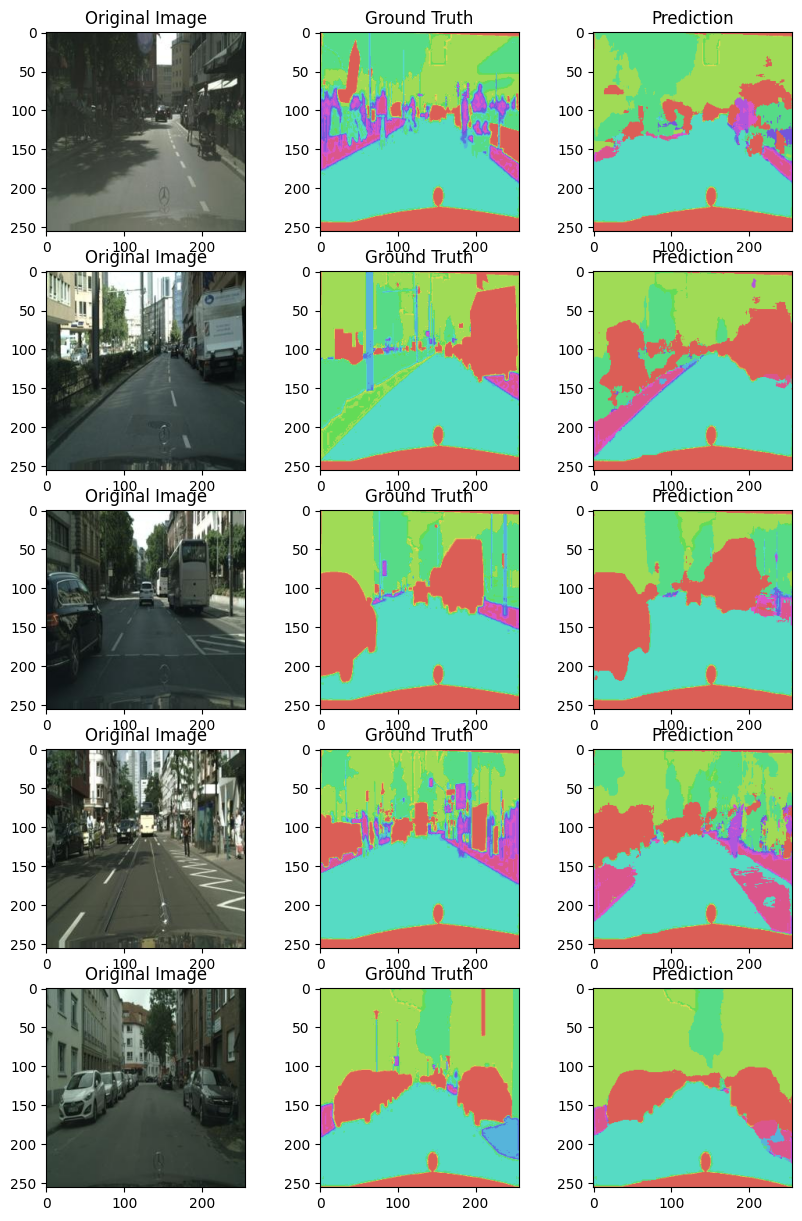

In [24]:
def visualize_predictions(model, val_gen, num_samples=5):
    imgs, masks = next(val_gen)
    preds = model.predict(imgs)
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 15))
    for i in range(num_samples):
        axes[i, 0].imshow(imgs[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 1].imshow(give_color_to_seg_img(np.argmax(masks[i], axis=-1)))
        axes[i, 1].set_title("Ground Truth")
        axes[i, 2].imshow(give_color_to_seg_img(np.argmax(preds[i], axis=-1)))
        axes[i, 2].set_title("Prediction")
    plt.show()

visualize_predictions(model, val_gen, num_samples=5)

## Saving the Model

In [ ]:
model.save("hybrid_seg_model.h5")

## XAI in predicting the model through GRAD-CAM

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


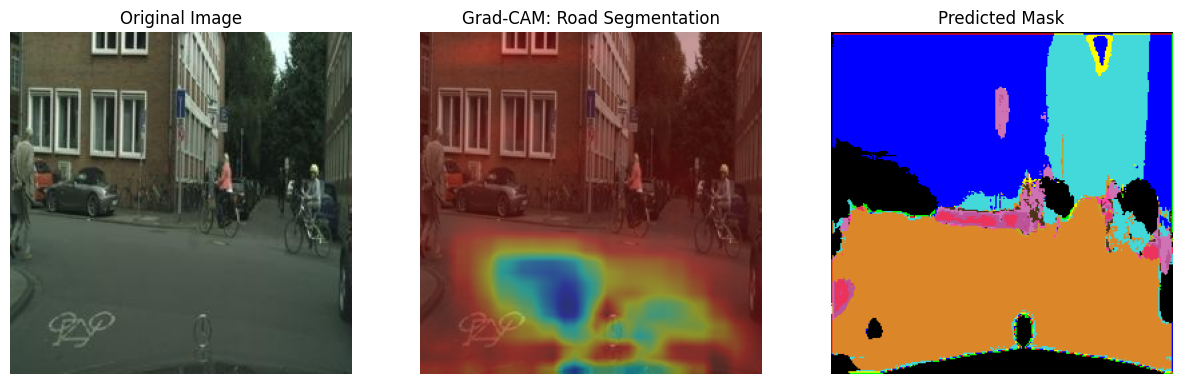

In [28]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import random

# Load trained model
model_path = "hybrid_seg_model.h5"  # Update this path if needed
trained_model = tf.keras.models.load_model(model_path)

# Select correct target layer
target_layer = trained_model.get_layer("conv2d_89")  # Ensure this layer exists

# Build a model to get the target layer's output
grad_model = tf.keras.models.Model(
    inputs=[trained_model.input],
    outputs=[target_layer.output, trained_model.output]
)

# Fetch an image from validation generator
val_batch = next(val_gen)
image = val_batch[0][random.randint(0, len(val_batch[0]) - 1)]  # Pick a random image from batch

# Ensure the image is in correct format
if image.shape[-1] == 1:  # Convert grayscale to RGB
    image = np.repeat(image, 3, axis=-1)

# Normalize image correctly
image = (image - np.min(image)) / (np.max(image) - np.min(image))
image = (image * 255).astype(np.uint8)  # Convert back to 0-255 range

def compute_gradcam(image, model, target_layer, class_idx=1):
    """Computes Grad-CAM heatmap for a segmentation model."""
    img_tensor = np.expand_dims(image, axis=0)  # Add batch dimension

    with tf.GradientTape() as tape:
        conv_output, predictions = model(img_tensor)
        
        if len(predictions.shape) == 4:  # (batch, H, W, num_classes)
            loss = tf.reduce_mean(predictions[:, :, :, class_idx])  # Compute mean loss for class
        else:
            raise ValueError(f"Unexpected prediction shape: {predictions.shape}")

    # Compute gradients
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]  # Remove batch dimension
    heatmap = np.mean(conv_output * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)  # Prevent division by zero
    return heatmap

def apply_heatmap(image, heatmap, alpha=0.4):
    """Overlays the heatmap on the original image."""
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)
    
    if len(image.shape) == 2 or image.shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    superimposed_img = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

def give_color_to_seg_img(segmentation_map):
    """Assigns colors to the segmentation mask."""
    num_classes = np.max(segmentation_map) + 1  # Dynamically get the number of classes
    color_map = np.array([
        [0, 0, 0],       # Class 0: Background (Black)
        [0, 255, 0],     # Class 1: Road (Green)
        [255, 0, 0],     # Class 2: Pedestrian (Red)
        [0, 0, 255],     # Class 3: Vehicles (Blue)
        [255, 255, 0]    # Class 4: Other (Yellow)
    ], dtype=np.uint8)

    # Ensure color map is large enough
    if num_classes > len(color_map):
        extra_colors = np.random.randint(0, 255, size=(num_classes - len(color_map), 3))
        color_map = np.vstack([color_map, extra_colors])

    return color_map[segmentation_map]  # Assign colors to segmentation map


# Compute Grad-CAM heatmap
heatmap = compute_gradcam(image, grad_model, target_layer, class_idx=1)

# Overlay heatmap on image
superimposed_img = apply_heatmap(image, heatmap)

# Get predicted mask
preds = trained_model.predict(np.expand_dims(image, axis=0))
predicted_mask = np.argmax(preds[0], axis=-1)  # Convert softmax output to class index
colored_predicted_mask = give_color_to_seg_img(predicted_mask)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image.astype(np.uint8))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM: Road Segmentation")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(colored_predicted_mask)
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


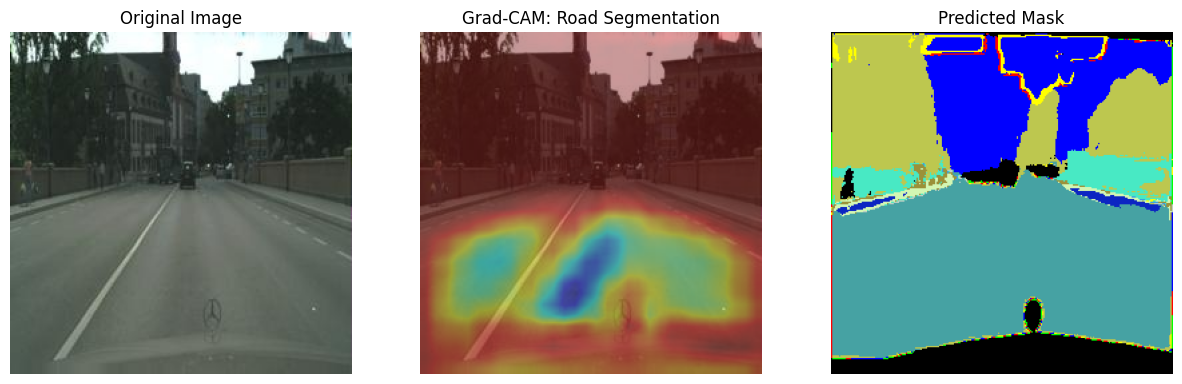

In [29]:
# Compute Grad-CAM heatmap
heatmap = compute_gradcam(image, grad_model, target_layer, class_idx=1)

# Overlay heatmap on image
superimposed_img = apply_heatmap(image, heatmap)

# Get predicted mask
preds = trained_model.predict(np.expand_dims(image, axis=0))
predicted_mask = np.argmax(preds[0], axis=-1)  # Convert softmax output to class index
colored_predicted_mask = give_color_to_seg_img(predicted_mask)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image.astype(np.uint8))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM: Road Segmentation")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(colored_predicted_mask)
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


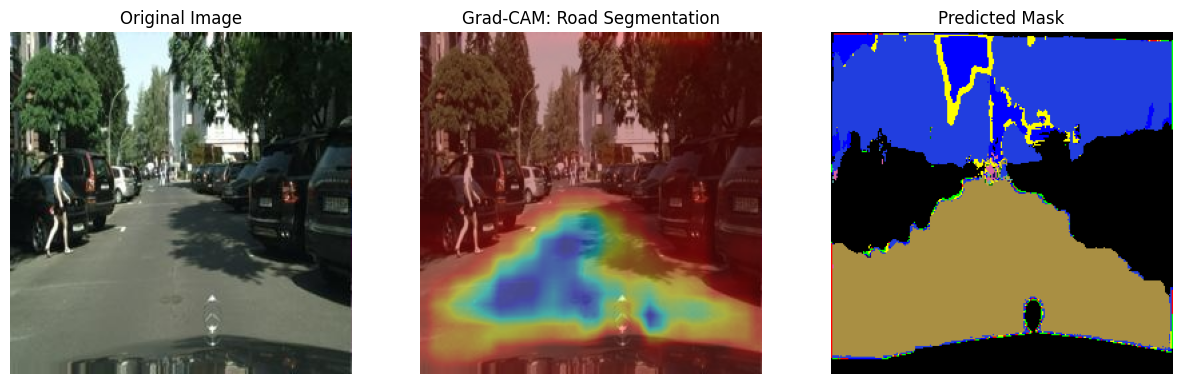

In [30]:
# Compute Grad-CAM heatmap
heatmap = compute_gradcam(image, grad_model, target_layer, class_idx=1)

# Overlay heatmap on image
superimposed_img = apply_heatmap(image, heatmap)

# Get predicted mask
preds = trained_model.predict(np.expand_dims(image, axis=0))
predicted_mask = np.argmax(preds[0], axis=-1)  # Convert softmax output to class index
colored_predicted_mask = give_color_to_seg_img(predicted_mask)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image.astype(np.uint8))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM: Road Segmentation")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(colored_predicted_mask)
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


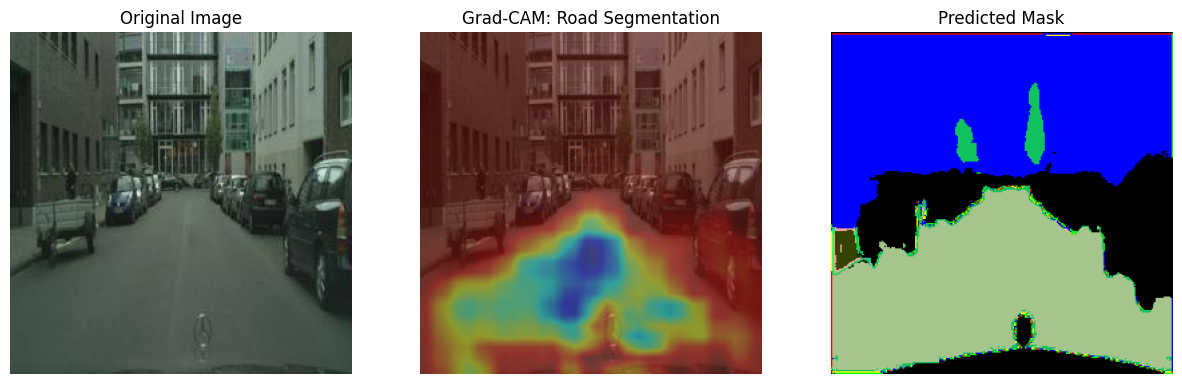

In [31]:
# Compute Grad-CAM heatmap
heatmap = compute_gradcam(image, grad_model, target_layer, class_idx=1)

# Overlay heatmap on image
superimposed_img = apply_heatmap(image, heatmap)

# Get predicted mask
preds = trained_model.predict(np.expand_dims(image, axis=0))
predicted_mask = np.argmax(preds[0], axis=-1)  # Convert softmax output to class index
colored_predicted_mask = give_color_to_seg_img(predicted_mask)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image.astype(np.uint8))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM: Road Segmentation")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(colored_predicted_mask)
plt.title("Predicted Mask")
plt.axis("off")

plt.show()
